In [1]:
from pymongo import MongoClient
import pandas as pd  
import numpy as np 

client = MongoClient('localhost', 27017)
db = client['']

tweets = pd.DataFrame(list(db[''].find()))

In [2]:
data = pd.DataFrame(columns=['Tweets'])
data['Tweets'] = tweets['text']
data['Id'] = tweets['_id']
data['len']  = np.array([len(tweet) for tweet in data['Tweets']])
user = list()
for i in range(0,len(tweets)):
    user.append(tweets['user'][i]['name'])
data['user'] = np.array(user)

In [3]:
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
import re

def replace_urls(in_string, replacement=None):
   
    replacement = '<-URL->' if replacement is None else replacement
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    return re.sub(pattern, replacement, in_string)


def tokenize_and_stem(doc):
    
    #split into words
    tokens = word_tokenize(doc)
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # remove words shorter than 4 char
    tokens = [word for word in tokens if len(word)>3]
    # handle URLS
    tokens = [replace_urls(w) for w in tokens]
    
    # stemming of words
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]

    return tokens

In [14]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from nltk.corpus import stopwords
 
    
documents = data['Tweets']

myStopWords=set(stopwords.words('italian')
                +stopwords.words('english'))   
    

"""
The most effortless way is by filtering out infrequent words. 
You can achieve this by setting input arguments as follows [1]:

min_df: To ignore terms that have a document frequency lower than the min_df. 
If float, the parameter represents a proportion of documents, integer absolute counts.

max_features: To consider only the top max_features ordered by term frequency across the corpus. 

This is useful if you have strict limit on the size of TF-IDF transformed features.
When dealing with a relatively large corpus, using min_df of 5, 10, or 50 reduces the size of the vocabulary
significantly while maintaining (or often improving) the accuracy.
"""    
    
    
vectorizer = TfidfVectorizer(stop_words=myStopWords, 
                             use_idf=True, 
                             tokenizer=tokenize_and_stem,
                             ngram_range=(1,3)
                             ,min_df=200, max_features=200)
X = vectorizer.fit_transform(documents)

print(X.shape)

true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster :", i),
    for ind in order_centroids[i, :3]:
        print(' ', terms[ind]),
    print

(27959, 45)
Top terms per cluster:
Cluster : 0
  officialasroma
  asroma
  roma
  forza
  prima
  final
  grazi
  oggi
  dopo
  fare
Cluster : 1
  grazi
  iamcallo
  circuit
  love
  dopo
  quando
  ecco
  italia
  nuovo
  thank
Cluster : 2
  roma
  forza
  grazi
  love
  domani
  sera
  live
  ecco
  prima
  stasera
Cluster : 3
  grand
  moscagol
  circuit
  grazi
  roma
  iamcallo
  robertavinci
  così
  ancora
  oggi
Cluster : 4
  oggi
  roma
  grazi
  anni
  follow
  asroma
  così
  dopo
  fatto
  prima
Cluster : 5
  auguri
  buon
  grazi
  anni
  oggi
  grand
  moscagol
  officialasroma
  roma
  sempr
Cluster : 6
  solo
  quando
  grazi
  sempr
  fare
  cosa
  asroma
  roma
  esser
  grand
Cluster : 7
  sempr
  grazi
  grand
  quando
  forza
  roma
  oggi
  bene
  anni
  robertavinci
Cluster : 8
  tvdellosport
  live
  stasera
  domani
  prima
  nuovo
  dopo
  cosa
  buon
  ancora
Cluster : 9
  asroma
  roma
  ecco
  domani
  dopo
  forza
  live
  sera
  final
  esser


Counter({1: 24024, 9: 589, 2: 549, 4: 534, 3: 463, 7: 411, 8: 371, 6: 370, 0: 348, 5: 300})
Silouette_score:  0.5478237755544306


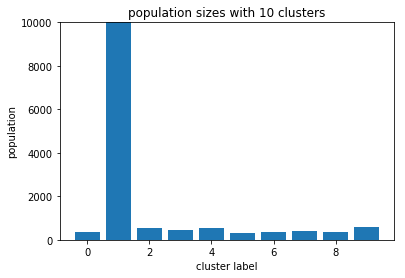

In [15]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import collections


plt.bar(range(len(set(model.labels_))), np.bincount(model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(true_k));

# truncate y axis to see the rest better
plt.ylim(0,10000);


print (collections.Counter(model.labels_))
print ('Silouette_score: ',silhouette_score(X, model.labels_))
